In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

import PySpice
import logging

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

logger.setLevel(logging.CRITICAL)


from PySpice.Probe.Plot import plot
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

from PySpice.Probe.Plot import plot
from scipy import signal as sig
import random

from UsefulFunction import *

from CircuitSimulator import Circuit_Simulator

from data_generators_module import Data_Generators

from Plots_and_Cost import *
from pulse_pause_modulation import *
from simulated_annealing import *

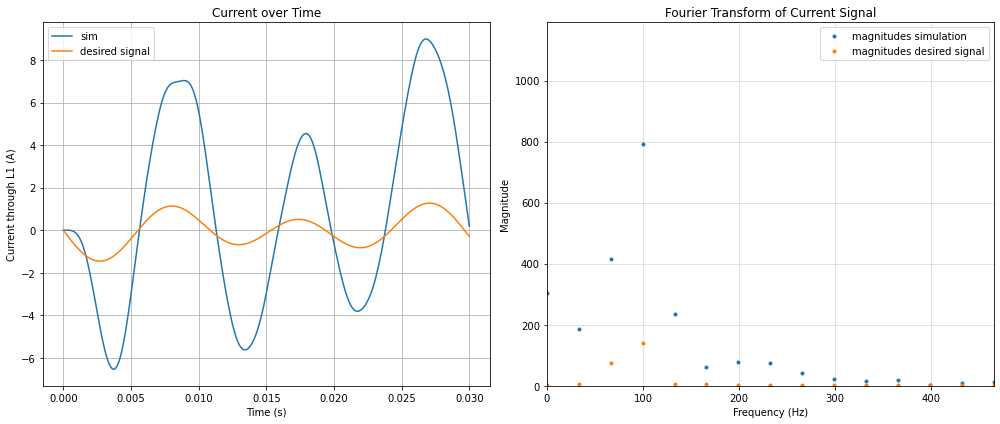

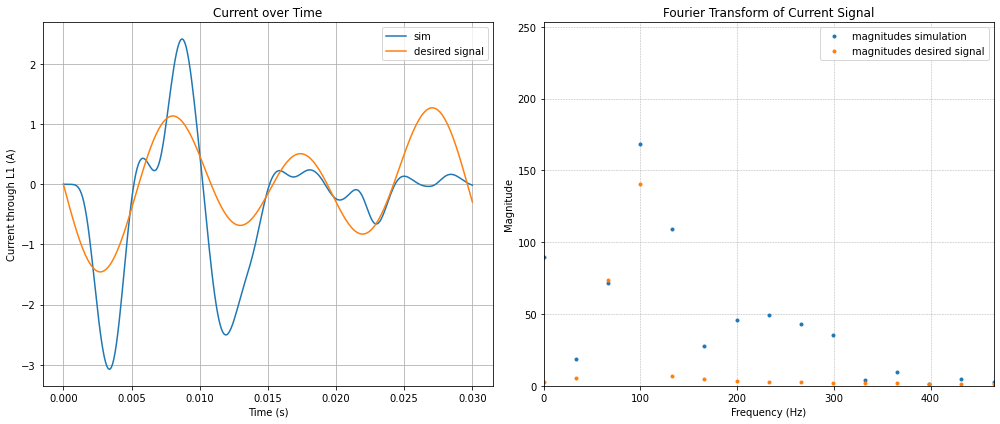

costs Joel:  0.464769161923975 Cost Maurice  0.01998938925961903


In [2]:
"""1. Set the Global Parameters"""

R = 0.31409132648802074 # [Ohm]
L = 0.002973796091926029 # [Henry]
U = 12
period = 30
highest_frequency = 3e2
global_params = [R,L, U, period, highest_frequency]


"""2. Input the Desired Frequencies (Signal) and the Number of Switches"""
N = int(2048*period/100)//2 #techically feasible: 2048 in 100 ms
freqs = np.array([100, 70]) #freq = 1000*Anz_peaks/period
coeffs = np.array([1j, 0.5j])

#validity check of the input
#zu kleine gesamtamplitude kann eine schlechte approximation herbeiführen
time = np.linspace(0, period/1000, N)
max_amp = np.max(reconstruct_signal(time, freqs, coeffs))
max_freq = np.max(freqs)
if(max_amp*max_freq*2*np.pi > U/L):
    raise RuntimeError("Zu Hohe Frequenzen/Amplituden, nicht sinvoll darstellbar")
if(min(freqs) < 1000/(period/2)):
    raise RuntimeError("Lower Limit erreicht: zu tiefe Frequenzen")

"""3 . Choose your starting Point"""
"""3.1 Option 1 - Pulse Pause Modulation"""
max_np = 1e3*period/(2*np.pi) #maximum number of peaks able to create (angenommen die maximal Frequenz, die wir erzeugen wollen ist 1e3)
max_height_signal = period/(4*max_np)*(U/L)


'''preparation before simulated annealing'''
#Joel's Version
signal = reconstruct_signal(time, freqs, coeffs*(1j))
input, sign = ppm_joel(signal, time, N, global_params)
data1 = data_pulse_pause(input, sign, global_params)

#Maurice's Version
signal = reconstruct_signal(time, freqs, coeffs)
input, sign = ppm_maurice(signal, time, N, global_params)
data2 = data_pulse_pause(input, sign, global_params)

#Plot the results
time = np.arange(0, period/1000 + 1e-4, 1e-4)
signal = reconstruct_signal(time, freqs, coeffs)
c1, dummy = cost_data(data1, signal, global_params, True)
c2, dummy = cost_data(data2, signal, global_params, True)
print("costs Joel: ", c1,"Cost Maurice ", c2)


In [3]:
 """4. Optimize with Simmulated Annealing"""
max_iter, cooling_rate = 100, 0.99 # high cooling rate = more exploration

#start with the minimum
data = data1 if c1 < c2 else data2
c = min(c1,c2)
print("Start Cost: ", c)
#SA_min, costs = simmulated_annealing_data(signal, data, max_iter, cooling_rate, global_params)
#c_SA, dummy = cost_data(SA_min,signal, global_params, True)
#plt.plot(np.arange(0, max_iter), costs)



Start Cost:  0.01998938925961903


In [4]:
"""5. Customize the Cost Function"""
def new_cost_function(self, signal):
    # Signalfehler (Summe der quadrierten Fehler)
    dt = self.time[1] - self.time[0]
    signal_error = np.sum(dt * (self.current - signal)**2)

    # Anzahl der Schaltungen berechnen
    anz_switches = 0
    for i in range(1, len(self.data)):
        anz_switches += np.sum(self.data[i][1] != self.data[i-1][1])
        
    

    # Gewichtungsfunktion
    k = 1e30  # Steuerparameter (anpassen je nach Problem) -> je grösser, desto weniger relevant sind die anzahl Switches
    weight = anz_switches / (anz_switches + k)
    
    # Kostenfunktion
    cost = signal_error + weight * anz_switches

    return cost, (self.current-signal)**2 #anz_switches

Circuit_Simulator.cost_function = new_cost_function